<a href="https://colab.research.google.com/github/devangi2000/Deep-Learning/blob/master/Tutorial_03_autograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Link to PyTorch AutoGrad tutorial

https://pytorch.org/docs/stable/autograd.html

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from IPython.display import HTML, display


def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)


def show_scatterplot(X, colors, title=''):
    colors = colors.cpu().numpy()
    X = X.cpu().numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=30)
    # plt.grid(True)
    plt.title(title)
    plt.axis('off')


def plot_bases(bases, width=0.04):
    bases = bases.cpu()
    bases[2:] -= bases[:2]
    plt.arrow(*bases[0], *bases[2], width=width, color=(1,0,0), zorder=10, alpha=1., length_includes_head=True)
    plt.arrow(*bases[1], *bases[3], width=width, color=(0,1,0), zorder=10, alpha=1., length_includes_head=True)


def show_mat(mat, vect, prod, threshold=-1):
    # Subplot grid definition
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=True,
                                        gridspec_kw={'width_ratios':[5,1,1]})
    # Plot matrices
    cax1 = ax1.matshow(mat.numpy(), clim=(-1, 1))
    ax2.matshow(vect.numpy(), clim=(-1, 1))
    cax3 = ax3.matshow(prod.numpy(), clim=(threshold, 1))

    # Set titles
    ax1.set_title(f'A: {mat.size(0)} \u00D7 {mat.size(1)}')
    ax2.set_title(f'a^(i): {vect.numel()}')
    ax3.set_title(f'p: {prod.numel()}')

    # Remove xticks for vectors
    ax2.set_xticks(tuple())
    ax3.set_xticks(tuple())
    
    # Plot colourbars
    fig.colorbar(cax1, ax=ax2)
    fig.colorbar(cax3, ax=ax3)

    # Fix y-axis limits
    ax1.set_ylim(bottom=max(len(prod), len(vect)) - 0.5)


colors = dict(
    aqua='#8dd3c7',
    yellow='#ffffb3',
    lavender='#bebada',
    red='#fb8072',
    blue='#80b1d3',
    orange='#fdb462',
    green='#b3de69',
    pink='#fccde5',
    grey='#d9d9d9',
    violet='#bc80bd',
    unk1='#ccebc5',
    unk2='#ffed6f',
)


def _cstr(s, color='black'):
    if s == ' ':
        return f'<text style=color:#000;padding-left:10px;background-color:{color}> </text>'
    else:
        return f'<text style=color:#000;background-color:{color}>{s} </text>'

# print html
def _print_color(t):
    display(HTML(''.join([_cstr(ti, color=ci) for ti, ci in t])))

# get appropriate color for value
def _get_clr(value):
    colors = ('#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
              '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
              '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
              '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e')
    value = int((value * 100) / 5)
    if value == len(colors): value -= 1  # fixing bugs...
    return colors[value]

def _visualise_values(output_values, result_list):
    text_colours = []
    for i in range(len(output_values)):
        text = (result_list[i], _get_clr(output_values[i]))
        text_colours.append(text)
    _print_color(text_colours)

def print_colourbar():
    color_range = torch.linspace(-2.5, 2.5, 20)
    to_print = [(f'{x:.2f}', _get_clr((x+2.5)/5)) for x in color_range]
    _print_color(to_print)


# Let's only focus on the last time step for now
# First, the cell state (Long term memory)
def plot_state(data, state, b, decoder):
    actual_data = decoder(data[b, :, :].numpy())
    seq_len = len(actual_data)
    seq_len_w_pad = len(state)
    for s in range(state.size(2)):
        states = torch.sigmoid(state[:, b, s])
        _visualise_values(states[seq_len_w_pad - seq_len:], list(actual_data))

## Autograd: automatic differentiation
The autograd package provides automatic differentiation for all operations on Tensors. It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every single iteration can be different.

In [2]:
import torch

In [5]:
# Create a 2x2 tensor with gradient-accumulation capabilities
x = torch.tensor([[1,2],
                  [3,4]], requires_grad = True,
                 dtype= torch.float32)
print(x)

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


In [6]:
# Deduct 2 from all elements

y = x -2
print(y)

tensor([[-1.,  0.],
        [ 1.,  2.]], grad_fn=<SubBackward0>)


In [7]:
# y was created as a result of an operation so it has a grad_fn
print(y.grad_fn)

In [8]:
# What's happening here?
print(x.grad_fn)

None


In [9]:
# Let's dig further
y.grad_fn

In [10]:
y.grad_fn.next_functions[0][0]

In [11]:
y.grad_fn.next_functions[0][0].variable

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)

In [12]:
# Do more operations on y

z = y * y * 3
a = z.mean() # average

print(z)
print(a)

tensor([[ 3.,  0.],
        [ 3., 12.]], grad_fn=<MulBackward0>)
tensor(4.5000, grad_fn=<MeanBackward0>)


In [14]:
!pip install torchviz

     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=d54982410c406b309836e2a9131e5f31d78ec87ae5fe38290ca383e77e234ea9
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


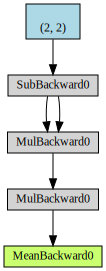

In [15]:
# Let's visualise the computational graph! (thks @szagoruyko)
from torchviz import make_dot
make_dot(a)

## Gradients
Let's backprop now out.backward() is equivalent to doing out.backward(torch.tensor([1.0]))

In [16]:
# Backprop
a.backward()

Print gradients $\frac{\text{d}a}{\text{d}x}$.

In [18]:
print(x)

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


In [17]:
# Compute it by hand BEFORE executing this
print(x.grad)

tensor([[-1.5000,  0.0000],
        [ 1.5000,  3.0000]])


You can do many crazy things with autograd!

With Great Flexibility Comes Great Responsibility

In [19]:
# Dynamic Graphs!

x = torch.randn(3, requires_grad=True)

y = x * 2
i = 0
while y.data.norm() < 1000:
    y = y * 2
    i += 1

print(y)

tensor([-172.2352, 1070.2888,  642.4351], grad_fn=<MulBackward0>)


In [20]:
# If we don't run backward on a scalar we need to specify the grad_output

gradients = torch.FloatTensor([0.1, 1.0, 0.0001])
y.backward(gradients)

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


In [21]:
# BEFORE executing this, can you tell what would you expect it to print?
print(i)

9


## Inference

In [22]:
# This variable decides the tensor's range below
n = 3

In [26]:
# Both x and w that allows gradient accumulation
x = torch.arange(1., n+1, requires_grad=True)
w = torch.ones(n, requires_grad=True)
print(x)
print(w)
z = w @ x
z.backward()
print(x.grad, w.grad, sep='\n')

tensor([1., 2., 3.], requires_grad=True)
tensor([1., 1., 1.], requires_grad=True)
tensor([1., 1., 1.])
tensor([1., 2., 3.])


In [27]:
# Only w that allows gradient accumulation
x = torch.arange(1., n+1)
w = torch.ones(n, requires_grad=True)
print(x)
print(w)
z = w @ x
z.backward()
print(x.grad, w.grad, sep='\n')

tensor([1., 2., 3.])
tensor([1., 1., 1.], requires_grad=True)
None
tensor([1., 2., 3.])


In [28]:
x = torch.arange(1., n + 1)
w = torch.ones(n, requires_grad=True)

# Regardless of what you do in this context, all torch tensors will not have gradient accumulation
with torch.no_grad():
    z = w @ x

try:
    z.backward() # PyTorch will throw an error here, since z has no grad accum.

except RuntimeError as e:
    print('Runtime Error! >:[')
    print(e)

Runtime Error! >:[
element 0 of tensors does not require grad and does not have a grad_fn
